In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Model Selection and Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from scipy.stats import boxcox

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Evaluation
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Visualization
%matplotlib inline


In [2]:
from google.colab import files

uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))

Saving heart_disease_dataset 00.csv to heart_disease_dataset 00.csv


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      1000 non-null   int64 
 1   Gender                   1000 non-null   object
 2   Cholesterol              1000 non-null   int64 
 3   Blood Pressure           1000 non-null   int64 
 4   Heart Rate               1000 non-null   int64 
 5   Smoking                  1000 non-null   object
 6   Alcohol Intake           1000 non-null   object
 7   Exercise Hours           1000 non-null   int64 
 8   Family History           1000 non-null   object
 9   Diabetes                 1000 non-null   object
 10  Obesity                  1000 non-null   object
 11  Stress Level             1000 non-null   int64 
 12  Blood Sugar              1000 non-null   int64 
 13  Exercise Induced Angina  1000 non-null   object
 14  Chest Pain Type          1000 non-null   

In [4]:
# Display the first few rows of the dataset
print(df.head())

   Age  Gender  Cholesterol  Blood Pressure  Heart Rate  Smoking  \
0   75  Female          228             119          66  Current   
1   48    Male          204             165          62  Current   
2   53    Male          234              91          67    Never   
3   69  Female          192              90          72  Current   
4   62  Female          172             163          93    Never   

  Alcohol Intake  Exercise Hours Family History Diabetes Obesity  \
0          Heavy               1             No       No     Yes   
1     Not at all               5             No       No      No   
2          Heavy               3            Yes       No     Yes   
3     Not at all               4             No      Yes      No   
4     Not at all               6             No      Yes      No   

   Stress Level  Blood Sugar Exercise Induced Angina   Chest Pain Type  \
0             8          119                     Yes   Atypical Angina   
1             9           70      

In [5]:
# Check for missing values in the dataset
df.isnull().sum().sum()

np.int64(0)

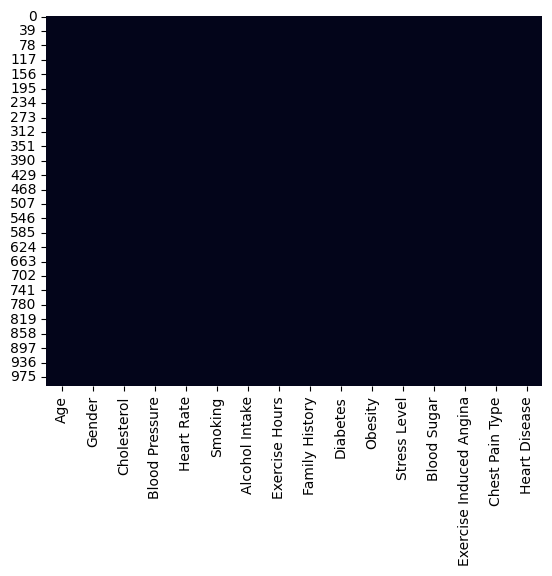

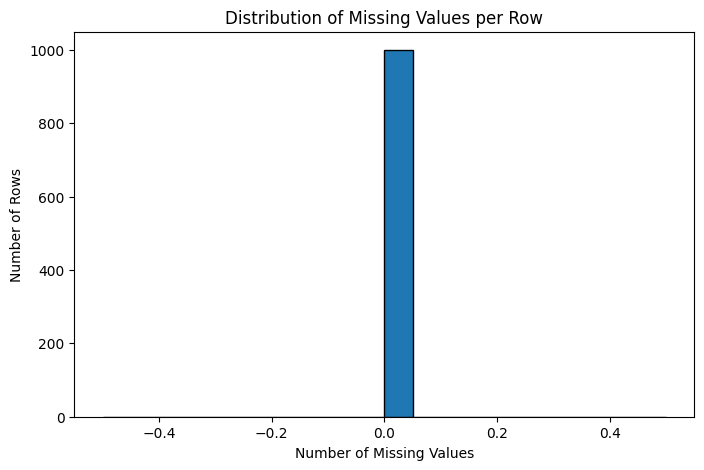

In [6]:
# Visually representing missing data patterns
sns.heatmap(df.isnull(), cbar=False)
plt.show()

# Plot the distribution of missing values
missing_per_row = df.isnull().sum(axis=1)
plt.figure(figsize=(8, 5))
plt.hist(missing_per_row, bins=20, edgecolor='black')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Values per Row')
plt.show()

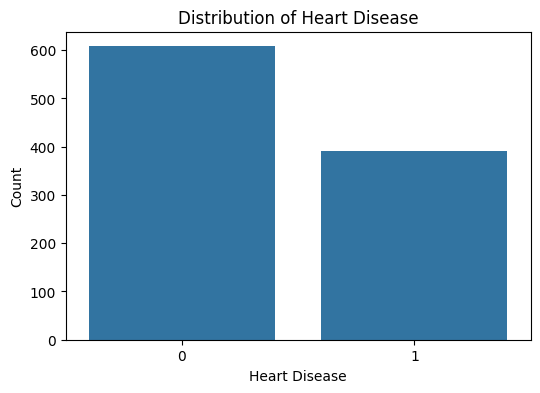

In [7]:
# Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Heart Disease')
plt.title('Distribution of Heart Disease')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.show()

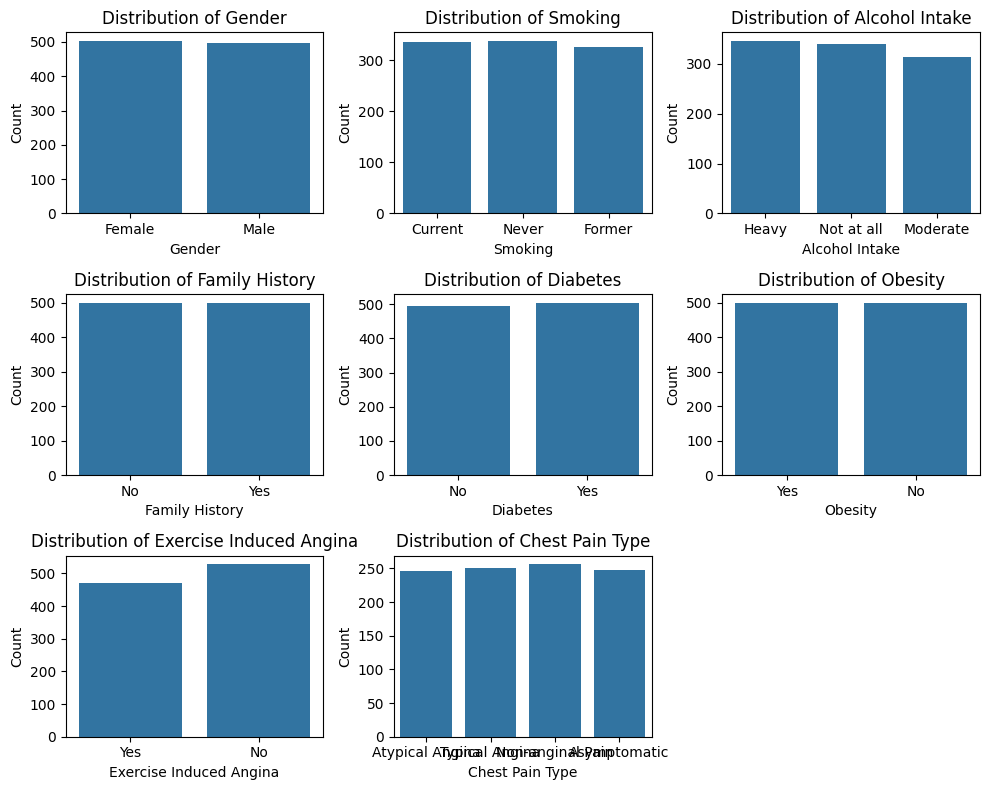

In [8]:
# Distribution of categorical variables
categorical_cols = ['Gender', 'Smoking', 'Alcohol Intake', 'Family History', 'Diabetes', 'Obesity', 'Exercise Induced Angina', 'Chest Pain Type']
plt.figure(figsize=(10, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

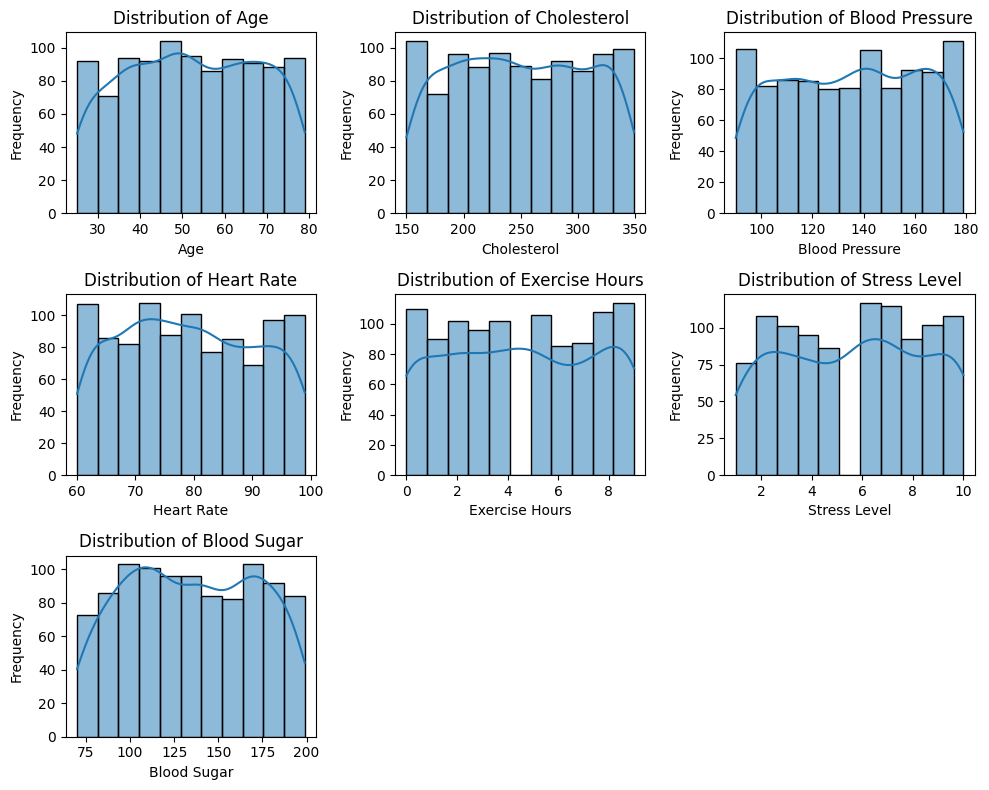

In [9]:
# Distribution of continuous variables
continuous_cols = ['Age', 'Cholesterol', 'Blood Pressure', 'Heart Rate', 'Exercise Hours', 'Stress Level', 'Blood Sugar']
plt.figure(figsize=(10, 8))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [10]:
# summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,52.293,15.727126,25.0,39.00,52.0,66.0,79.0
Cholesterol,1000.0,249.939,57.914673,150.0,200.00,248.0,299.0,349.0
Blood Pressure,1000.0,135.281,26.388300,90.0,112.75,136.0,159.0,179.0
Heart Rate,1000.0,79.204,11.486092,60.0,70.00,79.0,89.0,99.0
Exercise Hours,1000.0,4.529,2.934241,0.0,2.00,4.5,7.0,9.0
Stress Level,1000.0,5.646,2.831024,1.0,3.00,6.0,8.0,10.0
Blood Sugar,1000.0,134.941,36.699624,70.0,104.00,135.0,167.0,199.0
Heart Disease,1000.0,0.392,0.488441,0.0,0.00,0.0,1.0,1.0


Several features (like Cholesterol, Blood Sugar, Stress Level) have wide ranges or potential outliers

Some values are naturally bounded (e.g. Exercise Hours 0–9, Stress Level 1–10)

MinMaxScaler

It will scale everything to [0, 1], preserving the shape and spread but reducing sensitivity to extreme values. This also keeps categorical-like numerical features (like Stress Level) within intuitive bounds.

In [11]:
# summary statistics for categorical variables
df.describe(include='object')

,Gender,Smoking,Alcohol Intake,Family History,Diabetes,Obesity,Exercise Induced Angina,Chest Pain Type
count,1000,1000,1000,1000,1000,1000,1000,1000
unique,2,3,3,2,2,2,2,4
top,Female,Never,Heavy,No,Yes,No,No,Non-anginal Pain
freq,503,338,346,501,505,501,528,256


In [12]:
# check for outliers using the IQR method for the continuous features
Q1 = df[continuous_cols].quantile(0.25)
Q3 = df[continuous_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_cols] < (Q1 - 1.5 * IQR)) | (df[continuous_cols] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

,0
Age,0
Cholesterol,0
Blood Pressure,0
Heart Rate,0
Exercise Hours,0
Stress Level,0
Blood Sugar,0


In [13]:
# encode and save
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("Encoded DataFrame Preview:")
print(df[categorical_cols].head())

df.to_csv("encoded_dataset.csv", index=False)

from google.colab import files
files.download("encoded_dataset.csv")

Encoded DataFrame Preview:
   Gender  Smoking  Alcohol Intake  Family History  Diabetes  Obesity  \
0       0        0               0               0         0        1   
1       1        0               2               0         0        0   
2       1        2               0               1         0        1   
3       0        0               2               0         1        0   
4       0        2               2               0         1        0   

   Exercise Induced Angina  Chest Pain Type  
0                        1                1  
1                        1                3  
2                        1                1  
3                        1                2  
4                        1                0  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
target_column = "Heart Disease"
X = df.drop(columns=[target_column])
y = df[target_column]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

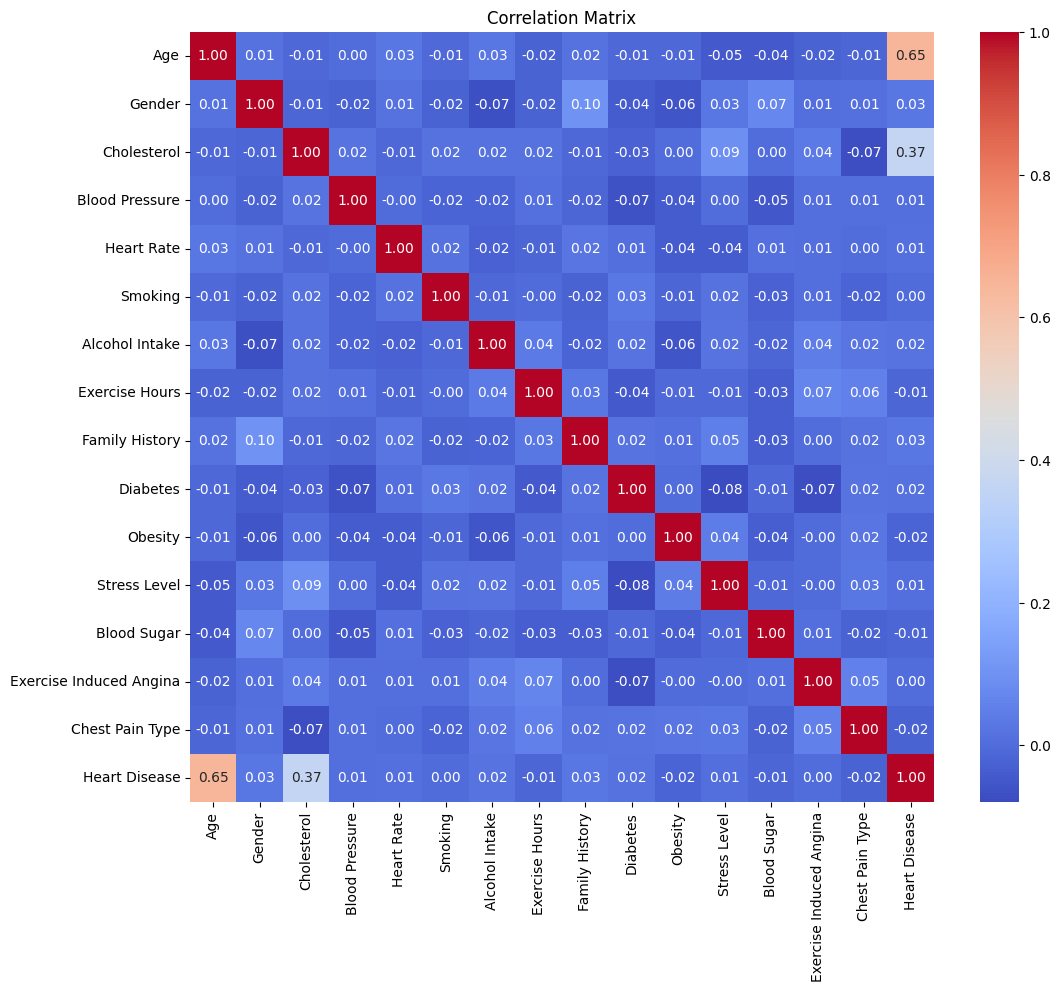

In [15]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

Insights:
1.	**Strongest Correlation with Target (Heart Disease):**
=	**Age** has the strongest positive correlation with Heart Disease (0.65)
- older individuals are more likely to have heart disease.
= **Cholesterol** has a moderate positive correlation (0.37) with heart disease
- higher cholesterol may contribute to risk.
=	Other variables show very weak or no linear correlation with heart disease.
2.	**Weak or No Correlation:**
=	Variables like Exercise Hours, Alcohol Intake, Obesity, and Blood Pressure show very low correlations (close to 0) with Heart Disease,
which may mean:
-	Their relationship might be non-linear,
-	Or they may not be strong predictors on their own.
3.	**Low Multicollinearity Between Features:**
=	No features appear to have extremely high correlation (close to ±1.0) with each other, which is a good sign
- low risk of multicollinearity.
=	This means most features bring unique information.


In [17]:
# Define target
X = df.drop('Heart Disease', axis=1)
y = df['Heart Disease']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (800, 15)
Testing set shape: (200, 15)


In [18]:
# Define the models with MinMaxScaler
models = {
    "Logistic Regression": Pipeline([
        ('scaler', MinMaxScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": Pipeline([
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    "Gradient Boosting": Pipeline([
        ('clf', GradientBoostingClassifier(random_state=42))
    ])
}


 Test Set Performance:

 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       122
           1       0.87      0.78      0.82        78

    accuracy                           0.87       200
   macro avg       0.87      0.85      0.86       200
weighted avg       0.87      0.87      0.87       200



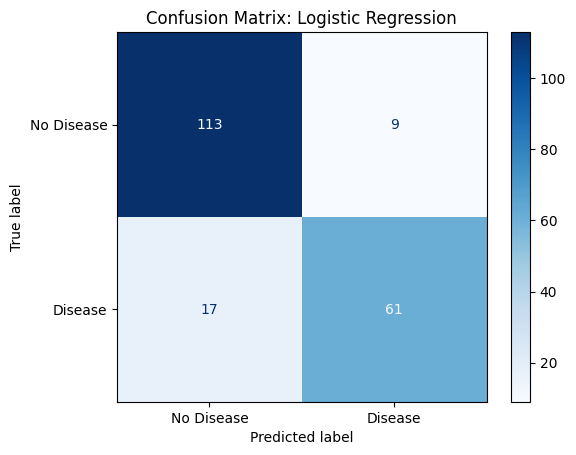

 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       122
           1       1.00      0.97      0.99        78

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



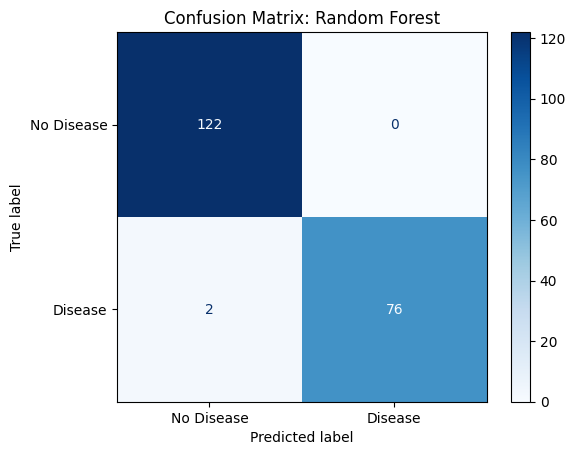

 Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00        78

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



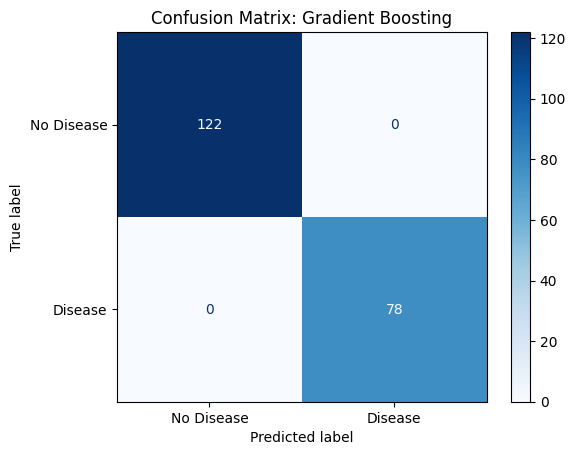

In [19]:
# Fit models and evaluate on test set
print("\n Test Set Performance:\n")

for name, pipeline in models.items():
    # Train model on training data
    pipeline.fit(X_train, y_train)

    # Predict on test data
    y_pred = pipeline.predict(X_test)

    # Classification Report
    print(f" {name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=["No Disease", "Disease"],
        cmap='Blues'
    )
    plt.title(f"Confusion Matrix: {name}")
    plt.show()


In [20]:
from sklearn.metrics import classification_report
import joblib

# 1. Get the pipeline
final_model = models["Random Forest"]

# 2. Fit the model on the training data
final_model.fit(X_train, y_train)

# 3. Predict on the test set
y_pred = final_model.predict(X_test)

# 4. Evaluate performance
print("Random Forest - Test Set Classification Report:")
print(classification_report(y_test, y_pred))

# 5. Save the trained model
joblib.dump(final_model, "random_forest_model.pkl")
print("Model saved as 'random_forest_model.pkl'")


Random Forest - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       122
           1       1.00      0.97      0.99        78

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

Model saved as 'random_forest_model.pkl'


In [21]:
# Load the saved model
loaded_model = joblib.load("random_forest_model.pkl")


In [22]:
# Pick 3 random samples
samples = X_test.sample(3, random_state=42)
true_labels = y_test.loc[samples.index].values

# Predict on the samples
predictions = loaded_model.predict(samples)
probabilities = loaded_model.predict_proba(samples)

# Display results
print("Sample Prediction Test:")
for i in range(len(samples)):
    print(f"\nSample #{i+1}")
    print(samples.iloc[i])
    print(f"= Predicted: {int(predictions[i])} (Confidence: {probabilities[i][int(predictions[i])]:.2f})")
    print(f"= Actual: {int(true_labels[i])}")


Sample Prediction Test:

Sample #1
Age                         59
Gender                       0
Cholesterol                180
Blood Pressure             127
Heart Rate                  70
Smoking                      2
Alcohol Intake               1
Exercise Hours               4
Family History               1
Diabetes                     1
Obesity                      0
Stress Level                 2
Blood Sugar                122
Exercise Induced Angina      0
Chest Pain Type              2
Name: 67, dtype: int64
= Predicted: 0 (Confidence: 0.88)
= Actual: 0

Sample #2
Age                         58
Gender                       1
Cholesterol                297
Blood Pressure              90
Heart Rate                  72
Smoking                      0
Alcohol Intake               2
Exercise Hours               6
Family History               1
Diabetes                     0
Obesity                      0
Stress Level                10
Blood Sugar                104
Exercise Induced 

In [27]:
# Load the test dataset and trained model
from google.colab import files

uploaded = files.upload()
test_set = pd.read_csv(next(iter(uploaded)))
loaded_model = joblib.load("random_forest_model.pkl")

# Make predictions
predictions = loaded_model.predict(test_set)

# Combine the predictions with the test data
results = test_set.copy()
results['Predicted Heart Disease'] = predictions

# Save the results to CSV
results.to_csv("predicted_results.csv", index=False)

# Download the file
from google.colab import files
files.download("predicted_results.csv")


Saving Dsynthetic_test_data.csv to Dsynthetic_test_data.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>